A replication for certain plots/results in R can be found here:
https://christophj.github.io/replicating/r/replicating-goyal-welch-2008/

## Imports

In [84]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS

from helper import get_statistics as help_get_stat
from helper import get_monthly_statistics as help_get_monthly_stats

In [85]:
# use notebook working directory; data is in the parent directory
notebook_dir = Path.cwd().parent
file_path_monthly = notebook_dir / "data" / "GW05_original_monthly.csv"
file_path_quarterly = notebook_dir / "data" / "GW05_original_quarterly.csv"
file_path_yearly = notebook_dir / "data" / "GW05_original_annual.csv"
data_monthly = pd.read_csv(file_path_monthly, sep=';', decimal=',')
data_quarterly = pd.read_csv(file_path_quarterly, sep=';', decimal=',')
data_annual = pd.read_csv(file_path_yearly, sep=';', decimal=',')
data_monthly['yyyymm'] = pd.to_datetime(data_monthly['yyyymm'], format='%Y%m')
data_monthly.rename(columns={'yyyymm': 'date'}, inplace=True)
data_annual.set_index('yyyy', inplace=True)


## Replicating annual log equity premium

In [86]:
# create 'missing' columns
data_annual['dp'] = np.log(data_annual["D12"]) - np.log(data_annual["Index"]) # dividend price ratio
data_annual['dy'] = np.log(data_annual["D12"]) - np.log(data_annual["Index"].shift(1)) # dividend yield
data_annual['de'] = np.log(data_annual["D12"]) - np.log(data_annual["E12"]) # dividend payout ratio
data_annual.loc[:, 'equity_premium'] = np.log1p(data_annual['CRSP_SPvw']) - np.log1p(data_annual['Rfree'])

In [87]:
# annual excess return from 1926 to 2005
data_annual['equity_premium'].describe()

count    80.000000
mean      0.060632
std       0.196858
min      -0.621098
25%      -0.050916
50%       0.086896
75%       0.197970
max       0.433438
Name: equity_premium, dtype: float64

These equity premia are close to the ones from Goyal/Welch (2008, p.1457). They differ slightly because I use the updated data from 2024 and some of the values for Rfree and ret were updated (even the values for 1926 were updated, which seems a bit far back). Following Plot is nearly identical to Figure 1 from [GW2003](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=300750).

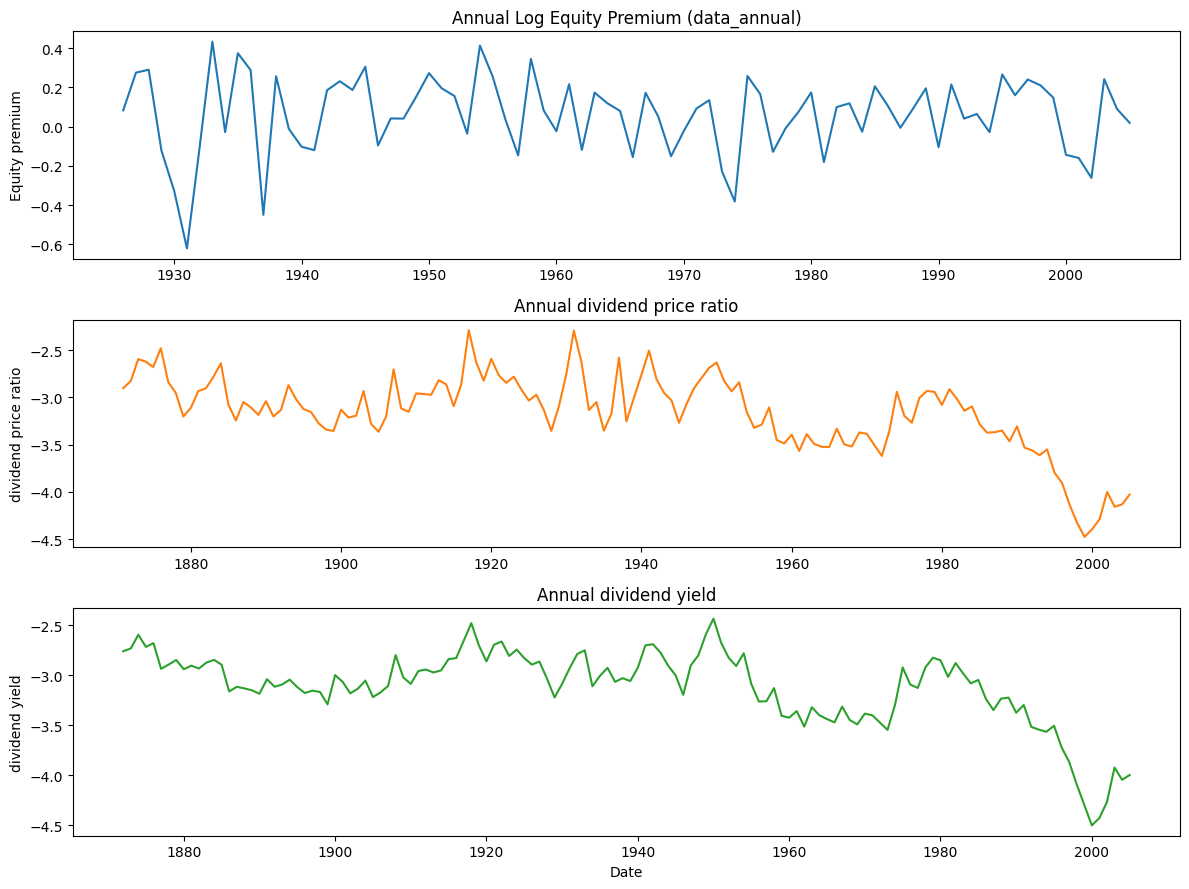

In [88]:
# plot premium over time
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=False)

# top: annual series from data_annual
axes[0].plot(data_annual.index, data_annual['equity_premium'], color='C0')
axes[0].set_title('Annual Log Equity Premium (data_annual)')
axes[0].set_ylabel('Equity premium')

# middle: annual series from computed annual dataframe
axes[1].plot(data_annual.index, data_annual['dp'], color='C1')
axes[1].set_title('Annual dividend price ratio')
axes[1].set_ylabel('dividend price ratio')

# bottom: monthly series (datetime index)
axes[2].plot(data_annual.index, data_annual['dy'], color='C2')
axes[2].set_title('Annual dividend yield')
axes[2].set_ylabel('dividend yield')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

## Getting the statistics for Table 1 - annual data
Note that I will not use data before 1926 for the equity premium, because returns with dividens only start in 1926 for the uploaded dataset. Plus, the data quality might also be questionable for this early period.

The following is a sample run through the code, I will later just call a function for that to maintain readability for this notebook.

In [89]:
dep = 'equity_premium'
start = 1927; end = 2005
ts_in_sample = data_annual.loc[start:end]
# 1. Historical mean model
avg = ts_in_sample[dep].mean()
IS_error_mean = ts_in_sample[dep] - avg

In [90]:
# 2. OLS model with lagged independent variable
# Create lagged independent variable
indep = 'ntis'
lagged_indep = ts_in_sample[indep].shift(1)
# Drop NA values due to lag
valid_idx = lagged_indep.dropna().index
y = ts_in_sample.loc[valid_idx, dep]
X = lagged_indep.loc[valid_idx]
X_const = add_constant(X)
reg = OLS(y, X_const).fit()
IS_error_cond = reg.resid

In [91]:
IS_R2 = reg.rsquared
IS_R2_head = IS_R2 - (1 - IS_R2)*(len(IS_error_cond)-int(reg.df_resid))/(len(IS_error_cond)-1)

In [92]:
round(IS_R2_head*100, 2)

np.float64(8.57)

The 8.57% is close to the 8.15% in the paper.

In [93]:
# OOS ANALYSIS
est_periods_OOS = 20
OOS_error_M = []
OOS_error_C = []
for i in range(start + est_periods_OOS, end):
    # Actual Equity Risk Premium (ERP) at time i+1
    actual_ERP = data_annual.loc[i+1, dep]
    # Historical mean model forecast using data up to i
    avg_i = data_annual.loc[start:i, dep].mean()
    OOS_error_M.append(actual_ERP - avg_i)

    # OLS model forecast using data up to i
    ts_train = data_annual.loc[start:i]
    lagged_indep_train = ts_train[indep].shift(1)
    valid_idx_train = lagged_indep_train.dropna().index
    y_train = ts_train.loc[valid_idx_train, dep]
    X_train = lagged_indep_train.loc[valid_idx_train]
    X_train_const = add_constant(X_train)
    reg_OOS = OLS(y_train, X_train_const).fit()

    # Prepare new data for prediction (lagged independent variable at time i)
    x_new = data_annual.loc[i, indep]
    x_new_df = pd.DataFrame({indep: [x_new]})
    x_new_const = add_constant(x_new_df, has_constant='add')
    pred_ERP = reg_OOS.predict(x_new_const)[0]
    OOS_error_C.append(pred_ERP - actual_ERP)

In [94]:
MSE_M = np.mean(np.array(OOS_error_M)**2)
MSE_C = np.mean(np.array(OOS_error_C)**2)
OOS_R2 = 1 - (MSE_C / MSE_M)
T = len(valid_idx_train)
k = T - 1
OOS_R2_head = OOS_R2 - (1-OOS_R2)*(T-k)/(T-1)
print(f"OOS R^2: {OOS_R2_head*100}")
dRMSE = np.sqrt(MSE_M) - np.sqrt(MSE_C)
print(f"dRMSE: {dRMSE*100}")

OOS R^2: -5.594952810323099
dRMSE: -0.33855504273971604


## Replicating plots for annual data from Goyal/Welch (2008)
 Null hypothesis is that unconditional forecast is not inferior to conditional forecast. Therefore, critical values for OOS are for one-sided test. Critical values for IS are based on two-sided tests. They make annual predictions and have 3 specifications for the timeline. First, OOS Forecast begins after 20 years of data availability. Second starts OOS Forecast in 1965. Third, ignore all data before 1927, even for estimation.

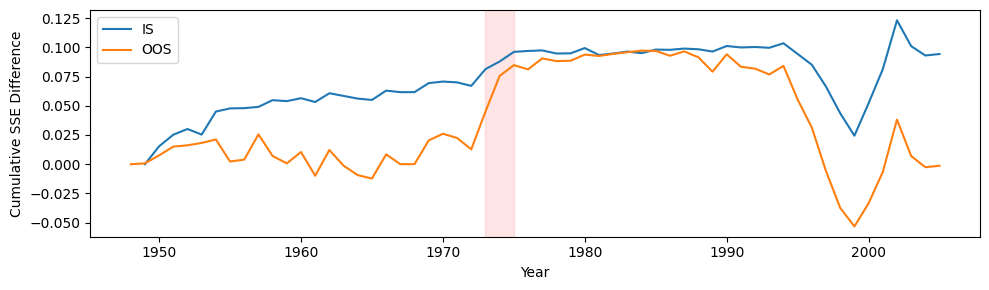

In [95]:
dp = help_get_stat(data_annual, indep='dp', dep='equity_premium', start=1927, end=2005, plot='yes')

For interpretation see GW2008: "These figures plot the IS and OOS performance of annual predictive regressions. Specifically,
these are the cumulative squared prediction errors of the NULL minus the cumulative squared prediction
error of the ALTERNATIVE. The ALTERNATIVE is a model that relies on predictive variables noted
in each graph. The NULL is the prevailing equity premium mean for the OOS graph, and the full-period
equity premium mean for the IS graph. The IS prediction relative performance is dotted (and usually
above), the OOS prediction relative perfomance is solid. An increase in a line indicates better performance
of the named model; a decrease in a line indicates better performance of the NULL. The blue band is the
equivalent of 95% two-sided levels, based on MSE-T critical values from McCracken (2004). (MSE-T is
the Diebold and Mariano (1995)
t-statistic modified by Harvey, Leybourne, and Newbold (1998)). The
right axis shifts the zero point to 1965. The Oil Shock is marked by a red vertical line."

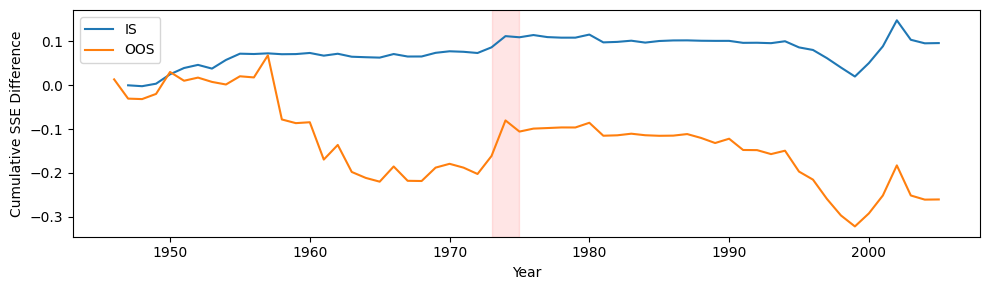

In [96]:
dy = help_get_stat(data_annual, indep='dy', dep='equity_premium', start=1925, end=2005, plot='yes')

In [97]:
eqis = help_get_stat(data_annual, indep='eqis', dep='equity_premium', start=1927, end=2005)
eqis

{'IS_R2_head_1927': 9.62,
 'IS_R2_head_OOS': 3.11,
 'IS_R2_head_1965': 3.94,
 'OOS_oR2': 1.93,
 'dRMSE': 0.26,
 'MSEf': 2.6}

In [98]:
bm = help_get_stat(data_annual, indep='b/m', dep='equity_premium', start=1927, end=2005)
bm

{'IS_R2_head_1927': 4.2,
 'IS_R2_head_OOS': 0.45,
 'IS_R2_head_1965': -2.2,
 'OOS_oR2': -13.48,
 'dRMSE': -0.95,
 'MSEf': -8.61}

In [99]:
ntis = help_get_stat(data_annual, indep='ntis', dep='equity_premium', start=1927, end=2005)
ntis

{'IS_R2_head_1927': 9.73,
 'IS_R2_head_OOS': -1.42,
 'IS_R2_head_1965': 1.3,
 'OOS_oR2': -5.54,
 'dRMSE': -0.34,
 'MSEf': -3.24}

In [100]:
ik = help_get_stat(data_annual, indep='ik', dep='equity_premium', start=1947, end=2005)
ik

{'IS_R2_head_1927': 6.55,
 'IS_R2_head_OOS': 1.92,
 'IS_R2_head_1965': 1.99,
 'OOS_oR2': 3.59,
 'dRMSE': 0.4,
 'MSEf': 4.03}

To summarize: It's a mess. Since i do not have data starting from 1871, the first forecast is always off, but actually still close to reported results. The forecasts starting 1965 and 1927 should be reproducible, but although here the results seem roughly similar, no exact reproduction was possible. What exactly is k and T? 
As I will not use annual data, I do not care for exact replication and just blame the authors for putting together such a confusing dataset and hope the monthly data will be more useful. In section 5.5 they also get vastly different results in their attempt to reproduce Campbell and Thompson.
I suspect one reason why the paper is anything but clean in the description of what they actually did, is that they made a lot of late-stage changes. Goyal and Welsh cite the [working paper from Campbell and Thompson](https://www.nber.org/papers/w11468) from 2005, which was only published in 2008. CT08 cite GW from 2004 in the 2005 working paper, but later GW from 2007. I would guess, that GW noticed that there is a pretty strong argument against the general statement that no variable can predict the S&P 500 returns for some profit and had to factor in the restrictions from CT05. Or maybe giving readers a hard time to verify results is just the mode of operation for the average economist. 

## Monthly Data EDA

In [101]:
data_monthly = data_monthly[data_monthly['date'] >= '1927-12-01']
print(data_monthly.head())
print(data_monthly.shape)

          date  Index     D12    E12       b/m     tbl     AAA     BAA  \
683 1927-12-01  17.66  0.7700  1.110  0.374689  0.0317  0.0446  0.0532   
684 1928-01-01  17.57  0.7767  1.133  0.378670  0.0331  0.0446  0.0535   
685 1928-02-01  17.26  0.7833  1.155  0.386077  0.0333  0.0446  0.0533   
686 1928-03-01  19.13  0.7900  1.177  0.363255  0.0327  0.0446  0.0532   
687 1928-04-01  19.75  0.7967  1.200  0.368095  0.0362  0.0446  0.0533   

        lty      ntis     Rfree      infl     ltr   corpr      svar  csp  \
683  0.0316  0.069365  0.002638 -0.001929  0.0072  0.0068  0.000674  NaN   
684  0.0321  0.051894  0.002755 -0.001932 -0.0036  0.0027  0.000939  NaN   
685  0.0318  0.047540  0.002771 -0.009718  0.0061  0.0068  0.000770  NaN   
686  0.0317  0.044087  0.002721  0.000000  0.0045  0.0041  0.001582  NaN   
687  0.0319  0.038282  0.003012  0.001951 -0.0004  0.0014  0.001712  NaN   

     CRSP_SPvw  CRSP_SPvwx  
683     0.0192      0.0143  
684    -0.0074     -0.0094  
685    -0.0

In [102]:
# show columns with only nan values
nan_columns = data_monthly.columns[data_monthly.isna().all()].tolist()
print("Columns with only NaN values:", nan_columns)
print('NAs per column:', data_monthly.isna().sum())

Columns with only NaN values: []
NAs per column: date            0
Index           0
D12             0
E12             0
b/m             0
tbl             0
AAA             0
BAA             0
lty             0
ntis            0
Rfree           0
infl            0
ltr             0
corpr           0
svar            0
csp           149
CRSP_SPvw       0
CRSP_SPvwx      0
dtype: int64


In [103]:
data_monthly['dp'] = np.log(data_monthly["D12"]) - np.log(data_monthly["Index"]) # dividend price ratio
data_monthly['dy'] = np.log(data_monthly["D12"]) - np.log(data_monthly["Index"].shift(1)) # dividend yield
data_monthly['ep'] = np.log(data_monthly["E12"]) - np.log(data_monthly["Index"])  # earnings price ratio
data_monthly['de'] = np.log(data_monthly["D12"]) - np.log(data_monthly["E12"]) # dividend payout ratio
# moving ten-year average of earnings divided by price
data_monthly['e10p'] = np.log(data_monthly['E12'].rolling(window=120).mean()) - np.log(data_monthly['Index'])
data_monthly['tms'] = data_monthly['AAA'] - data_monthly['tbl'] # term spread
data_monthly['dfy'] = data_monthly['BAA'] - data_monthly['AAA'] # default yield spread
# data_monthly['dfr']  --> currently not supported

GW08 themselves write "The Term Spread (tms)is the difference between the long term yield on government bonds and the Treasury-bill". The reference Fama and French 1989 however defines it as the difference between Aaa yield and one-month bill rate. The second definition gives results close to the ones from Table 3.

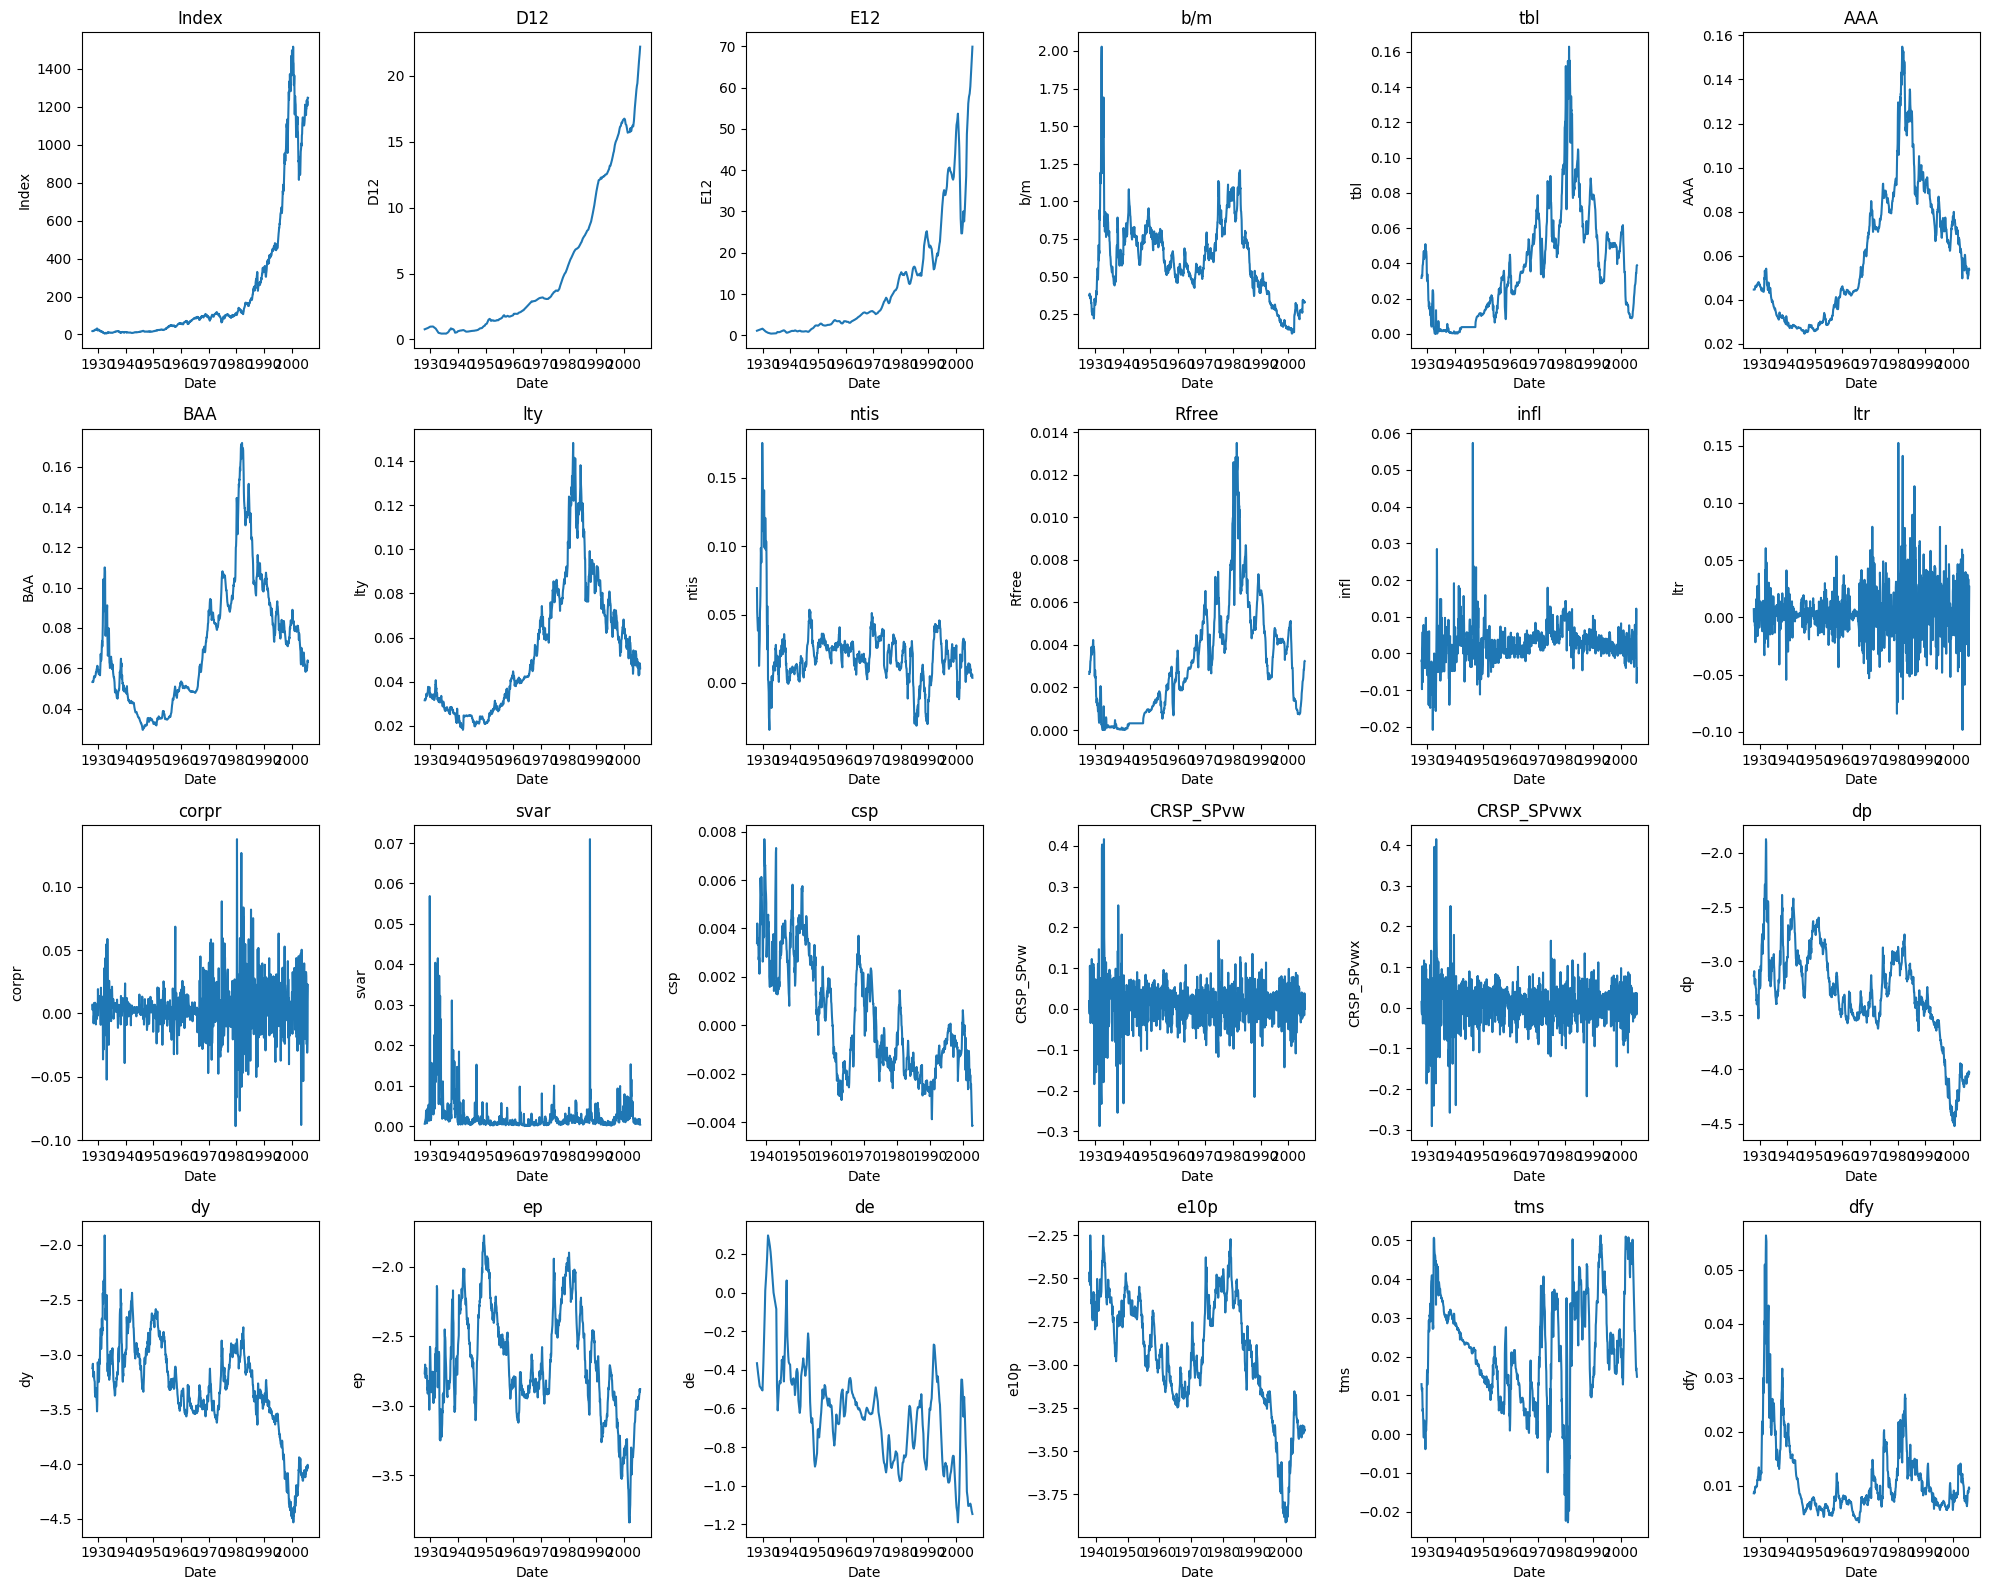

In [104]:
#plot every variable over time in a grid
import matplotlib.pyplot as plt
num_vars = data_monthly.shape[1] - 1  # exclude date column
num_cols = 6
num_rows = (num_vars + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
for i, column in enumerate(data_monthly.columns[1:]):  # exclude date column
    ax = axes[i // num_cols, i % num_cols]
    ax.plot(data_monthly['date'], data_monthly[column])
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
plt.tight_layout()
plt.show()

The variable to be forecasted is: "log equity premiums using CRSP’s definition of the S&P 500 including
dividends net of the (Ken French posted) Treasury return in nonoverlapping
periods at their native frequencies" (GWZ24). In the data this should be Rfree (for riskfree return) and CRSP_SPvw. A Rfree of 0.0049 means 0.49% return over a month with riskfree rate (annualized this would be > 5%). In 2008 paper, they also get the equity premium in levels.

In [105]:
data_monthly['log_equity_premium'] = np.log1p(data_monthly['CRSP_SPvw']) - np.log1p(data_monthly['Rfree'])
data_monthly['equity_premium'] = data_monthly['CRSP_SPvw'] - data_monthly['Rfree']

In [106]:
data_monthly['equity_premium'].describe()

count    937.000000
mean       0.006326
std        0.056530
min       -0.287675
25%       -0.021217
50%        0.009108
75%        0.036153
max        0.416125
Name: equity_premium, dtype: float64

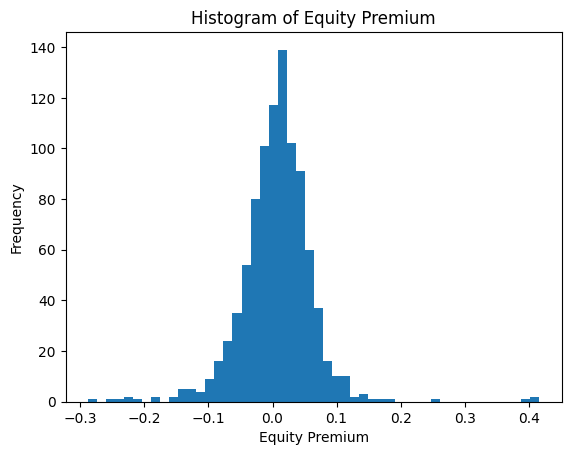

In [107]:
# plot histogram of excess returns
plt.hist(data_monthly["equity_premium"].dropna(), bins=50)
plt.title("Histogram of Equity Premium")
plt.xlabel("Equity Premium")
plt.ylabel("Frequency")
plt.show()

In [108]:
data_monthly["log_equity_premium"].describe()

count    937.000000
mean       0.004727
std        0.056182
min       -0.339070
25%       -0.021376
50%        0.009059
75%        0.035426
max        0.347814
Name: log_equity_premium, dtype: float64

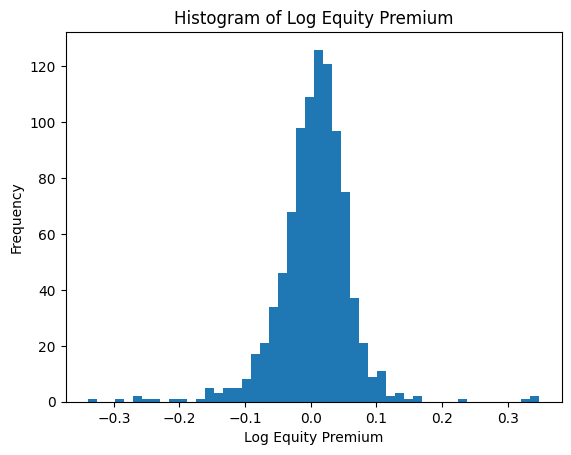

In [109]:
# plot histogram of excess returns
plt.hist(data_monthly["log_equity_premium"].dropna(), bins=50)
plt.title("Histogram of Log Equity Premium")
plt.xlabel("Log Equity Premium")
plt.ylabel("Frequency")
plt.show()

In [110]:
data_monthly.set_index('date', inplace=True)

## Reproducing Table 3 step by step - Monthly Data

In [111]:
# lty = help_get_stat(data_monthly, indep='lty', dep='equity_premium', start='1927-12-01', end='2005-12-01', plot='no')
# lty

There might be a small typo in description of table 3: The data period ends in December 2005, as this end period gives me the exact same values while December 2004 gives me small deviations from numbers in the table.

In [112]:
dep = 'equity_premium'
start='1927-12-01'; end='2005-12-01'
start_ts = pd.to_datetime(start)
end_ts = pd.to_datetime(end)

ts_in_sample = data_monthly.loc[start_ts:end_ts].copy()
# 1. Historical mean model
avg = ts_in_sample[dep].mean()
IS_error_mean = ts_in_sample[dep] - avg

In [113]:
# 2. OLS model with lagged independent variable
# Create lagged independent variable
indep = 'ltr'
lagged_indep = ts_in_sample[indep].shift(1)
# Drop NA values due to lag
valid_idx = lagged_indep.dropna().index
y = ts_in_sample.loc[valid_idx, dep]
X = lagged_indep.loc[valid_idx]
X_const = add_constant(X)
reg = OLS(y, X_const).fit()
EXPECTED_SIGN = np.where(float(reg.params[indep])>0, 1, -1)
IS_error_cond = reg.resid

In [114]:
# Truncate the model to never predict negative equity premium
# raw in-sample predictions
preds_insample = reg.predict(X_const)

# truncated in-sample predictions: force negative forecasts to 0
preds_insample_trunc = np.maximum(preds_insample, 0.0)

# observed dependent values (aligned with preds)
y_insample = y

# SSE for truncated model and null (full-sample mean) model
SSE_trunc = np.sum((y_insample - preds_insample_trunc) ** 2)
SSE_null = np.sum((y_insample - y_insample.mean()) ** 2)

# in-sample R^2 (truncated forecasts)
IS_R2_trunc = 1.0 - SSE_trunc / SSE_null

# small-sample bias adjustment (as used elsewhere in notebook)
T = len(y_insample)
k = int(reg.df_resid) + 1
IS_R2_head_trunc = IS_R2_trunc - (1 - IS_R2_trunc) * (T - k) / (T - 1)

round(IS_R2_head_trunc * 100, 2)

np.float64(0.08)

In [115]:
IS_R2 = reg.rsquared
T = len(IS_error_cond)
k = int(reg.df_resid) + 1
IS_R2_head = IS_R2 - (1 - IS_R2)*(T-k)/(T-1)
round(IS_R2_head*100, 2)

np.float64(0.07)

In [116]:
# OOS ANALYSIS (seems like 20 years or 240 months as estimation period)
est_periods_OOS = 240
idx = data_monthly.index
start_pos = idx.searchsorted(start_ts, side='left')
end_pos = idx.searchsorted(end_ts, side='right') - 1

OOS_error_M = []
OOS_error_C = []
OOS_error_TU = []
num_truncated = 0
num_slope_zero = 0

for pos in range(start_pos + est_periods_OOS, end_pos):
    # Actual Equity Risk Premium (ERP) at time pos+1
    actual_ERP = data_monthly.iloc[pos + 1][dep]

    # Historical mean forecast using data up to pos (positional slice via iloc)
    avg_i = data_monthly.iloc[start_pos:pos + 1][dep].mean()
    OOS_error_M.append(actual_ERP - avg_i)

    # OLS model forecast using data up to pos (use iloc for positional slicing)
    ts_train = data_monthly.iloc[start_pos:pos + 1]
    lagged_indep_train = ts_train[indep].shift(1)
    valid_idx_train = lagged_indep_train.dropna().index
    y_train = ts_train.loc[valid_idx_train, dep]
    X_train = lagged_indep_train.loc[valid_idx_train]
    X_train_const = add_constant(X_train)
    reg_OOS = OLS(y_train, X_train_const).fit()

    # Prepare new data for prediction (lagged independent variable at time pos)
    x_new = data_monthly.iloc[pos][indep]
    x_new_df = pd.DataFrame({indep: [x_new]})
    x_new_const = add_constant(x_new_df, has_constant='add')

    # raw prediction
    pred_ERP = reg_OOS.predict(x_new_const)[0]
    OOS_error_C.append(pred_ERP - actual_ERP)

    if pred_ERP < 0:
        num_truncated += 1

    # Set coefficient to 0, if sign does not match expected sign
    if (reg_OOS.params[indep] * EXPECTED_SIGN) < 0:
        reg_OOS.params[indep] = 0.0
        num_slope_zero += 1

        # make prediction with slope set to zero
        pred_ERP_slope_zero = reg_OOS.predict(x_new_const)[0]

        # truncated prediction to not allow negative predicted equity premium
        pred_ERP_trunc = max(pred_ERP_slope_zero, 0)
        OOS_error_TU.append(pred_ERP_trunc - actual_ERP)

    else:
        if pred_ERP < 0:
            pred_ERP_trunc = max(pred_ERP, 0)
            OOS_error_TU.append(pred_ERP_trunc - actual_ERP)
        else:
            OOS_error_TU.append(pred_ERP - actual_ERP)

share_truncated = num_truncated/len(OOS_error_M)
share_slope_zero = num_slope_zero/len(OOS_error_M)

In [117]:
share_truncated

0.031609195402298854

In [118]:
share_slope_zero

0.3807471264367816

In [119]:
MSE_M = np.mean(np.array(OOS_error_M)**2)
MSE_C = np.mean(np.array(OOS_error_C)**2)
MSE_TU = np.mean(np.array(OOS_error_TU)**2)

In [120]:
OOS_R2 = 1 - (MSE_C / MSE_M)
T = len(valid_idx_train)
k = T - 1
OOS_R2_head = OOS_R2 - (1-OOS_R2)*(T-k)/(T-1)
print(f"OOS R^2: {round(OOS_R2_head*100, 2)}")

OOS_R2_T = 1 - (MSE_TU / MSE_M)
OOS_R2_head_T = OOS_R2_T - (1-OOS_R2_T)*(T-k)/(T-1)
print(f"OOS R^2 (truncated): {round(OOS_R2_head_T*100, 2)}")

dRMSE = np.sqrt(MSE_M) - np.sqrt(MSE_TU)
print(f"dRMSE: {round(dRMSE*100, 4)}")

OOS R^2: -0.63
OOS R^2 (truncated): 0.23
dRMSE: 0.007


## Check stats and plots

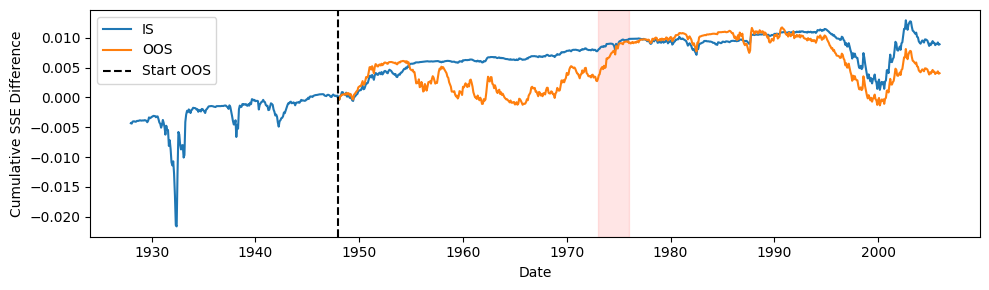

In [121]:
var = help_get_monthly_stats(data_monthly, indep='dp', start='1927-12-01', end='2005-12-01', plot='yes')

In [122]:
vars = ['de', 'svar', 'lty', 'ltr', 'infl', 'tms', 'tbl', 'dfy', 'dp', 'dy', 'ep', 'b/m', 'e10p', 'csp', 'ntis']

for var in vars:
    if var == 'csp':
        locals()[var] = help_get_monthly_stats(ts_df=data_monthly, indep=var, start='1937-05-01', end='2002-12-01', est_periods_OOS=240)
    else:
        locals()[var] = help_get_monthly_stats(ts_df=data_monthly, indep=var, start='1927-12-01', end='2005-12-01', est_periods_OOS=240)


In [123]:
# show all columns in pd.dataframe
pd.set_option('display.max_columns', None)

In [124]:
results = {}
for v in vars:
    val = locals().get(v)
    if val is None:
        continue
    if isinstance(val, pd.Series):
        results[v] = val.to_dict()
    elif isinstance(val, dict):
        results[v] = val
    else:
        # fallback: try to convert pandas objects or store scalar
        try:
            results[v] = dict(val)
        except Exception:
            results[v] = {'value': val}

# DataFrame with variables as rows
df_results = pd.DataFrame.from_dict(results, orient='index')

# keep original order and inspect / save
df_results = df_results.reindex(vars)
print(df_results)

      IS_R2_head_log  IS_R2_head  IS_R2_head_trunc  OOS_R2_head  share_T  \
de              0.02       -0.10             -0.10        -0.69     0.00   
svar           -0.09       -0.07             -0.07        -0.74     0.00   
lty            -0.03        0.02              0.02        -0.78    34.20   
ltr             0.04        0.07              0.08        -0.63     3.16   
infl           -0.00        0.15             -0.05         0.77     1.29   
tms             0.06        0.17              0.18         0.09     4.17   
tbl             0.10        0.20              0.15        -0.05    23.13   
dfy            -0.06        0.28              0.28        -0.48     3.88   
dp              0.12        0.33              0.29        -0.26    32.61   
dy              0.23        0.47              0.46        -1.06    54.60   
ep              0.52        0.54              0.45        -1.04    17.96   
b/m             0.45        0.81              0.88        -3.25    44.40   
e10p        

e10p and infl OOS seem to be quite a bit off.

- cay3 is not considered because it is not directly available for the forecaster. It's released 1-2 months later and adding this lag, makes it an insignificant predictor according to Goyal Welch 2008.
- eqis is not in the provided dataset
- Using December 2005 (the end of the dataset) instead of December 2004 gives results closer to GW08, although they say that end of data is December 2004

## Deep Learning Approach
Investigate whether non-linear DL prediction outperforms the simple OLS models.